In [1]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.date, event_log.actor_id,
        user.username, event_log.event_id, event.name
        from event_log
        join event on event.id = event_log.event_id
        join user on user.id = event_log.actor_id
        order by event_log.id
    """, db)
    df.set_index("id", inplace=True)
    
    return delete_consecutive_events(df)

def delete_consecutive_events(df):
    df.sort_values(["actor_id", "date"], inplace=True)
    df["time_diff_seconds"] = df["date"].diff().map(lambda x: x.total_seconds())
    
    to_delete = (df["time_diff_seconds"] >= 0) & (df["time_diff_seconds"] < 3)
    df.drop(df[to_delete].index, inplace=True)
    
    return df

event_log = read_event_log()
event_log.tail(100)

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,date,actor_id,username,event_id,name,time_diff_seconds
id,,,,,,
378277,2021-03-09 08:01:34,197401,Annika-Hemlein,5,entity/revision/add,8.0
378278,2021-03-09 08:01:41,197401,Annika-Hemlein,5,entity/revision/add,7.0
378281,2021-03-09 08:44:48,197401,Annika-Hemlein,5,entity/revision/add,2587.0
378287,2021-03-09 08:44:52,197401,Annika-Hemlein,5,entity/revision/add,4.0
378291,2021-03-09 08:45:00,197401,Annika-Hemlein,5,entity/revision/add,8.0
...,...,...,...,...,...,...
379200,2021-03-10 16:04:17,198070,Ryker,9,discussion/comment/create,-58325.0
379212,2021-03-10 20:34:46,198102,Vater,8,discussion/create,16229.0
379231,2021-03-11 08:11:54,198102,Vater,9,discussion/comment/create,41828.0


In [103]:
def compute_edits_per_day_per_user(df, event_ids=[5]):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=365.25*3)]
    df = df[df["event_id"].isin(event_ids)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

edits_per_day_per_user = compute_edits_per_day_per_user(event_log)
edits_per_day_per_user

,arekkas,Deleted,Simon,Sophia,Renate,Laura,Hannes,ESHA,aschreiber,inyono,...,Wo_Fo,Anton_Zikmund,Mathes,Katrin_K,Matheo,KerstinPecher,reallpk,Rami,Gianluca,Annika-Hemlein
date,,,,,,,,,,,,,,,,,,,,,
2018-03-12,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
2021-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,9.0,13.0,0.0,0.0,14.0,1.0,34.0
2021-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,20.0,0.0,0.0,17.0,6.0,65.0


```
+----+-----------------------------+-------------+
| id | name                        | description |
+----+-----------------------------+-------------+
|  1 | taxonomy/term/associate     | NULL        |
|  2 | taxonomy/term/create        | NULL        |
|  3 | license/object/set          | NULL        |
|  4 | entity/create               | NULL        |
|  5 | entity/revision/add         | NULL        |
|  6 | entity/revision/checkout    | NULL        |
|  7 | entity/link/create          | NULL        |
|  8 | discussion/create           | NULL        |
|  9 | discussion/comment/create   | NULL        |
| 10 | uuid/trash                  | NULL        |
| 11 | entity/revision/reject      | NULL        |
| 12 | taxonomy/term/update        | NULL        |
| 13 | uuid/restore                | NULL        |
| 14 | discussion/comment/archive  | NULL        |
| 15 | taxonomy/term/parent/change | NULL        |
| 16 | discussion/restore          | NULL        |
| 17 | taxonomy/term/dissociate    | NULL        |
| 18 | entity/link/remove          | NULL        |
+----+-----------------------------+-------------+
```

In [139]:
event_types = {
    "Inhalt": [5,6],
    "Kommentare": [8,9,14,16],
    "Reviewing": [6,11],
    "Taxonomy": [1,2,12,15,17],
    "Administration": [10,13,3]
}
event_types["Inhalt + Taxonomy"] = event_types["Inhalt"] + event_types["Taxonomy"]

In [141]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

from ipywidgets import interact

def show_author_count_plot(lower, event_type):
    display(Markdown(f"# Auswertung Anzahl Autor:innen (#Events >= {lower}; {event_type})"))
    
    df = compute_edits_per_day_per_user(event_log, event_types[event_type])
    df = df.rolling(30).sum()
    df.dropna(inplace=True)
    df["active"] = df.apply(lambda d: d.map(lambda e: e >= lower).sum(), axis=1)
    
    display(Markdown("### Plot"))
    df["active"].plot(figsize=(20,10))
    plt.show()
    
    idmax = df["active"].idxmax()
    current = df["active"][-1]
    one_year_before = df["active"][-365]
    
    display(Markdown("## Data"))
    display(Markdown(f"Current: {current}"))
    display(Markdown(f"One year before: {one_year_before}"))
    display(Markdown(f"Day of maximum: {idmax}"))
    display(df["active"].describe())
    

edits = widgets.IntSlider(
    value=10,
    min=1,
    max=150,
    step=1,
    description='Edits >= ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout_format='d'
)

interact(show_author_count_plot, event_type=event_types.keys(), lower=edits)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Edits >= ', max=150, min=1), D…

<function __main__.show_author_count_plot(lower, event_type)>

# Auswertung Anzahl Autor:innen (#Events >= 10; Inhalt)

### Plot

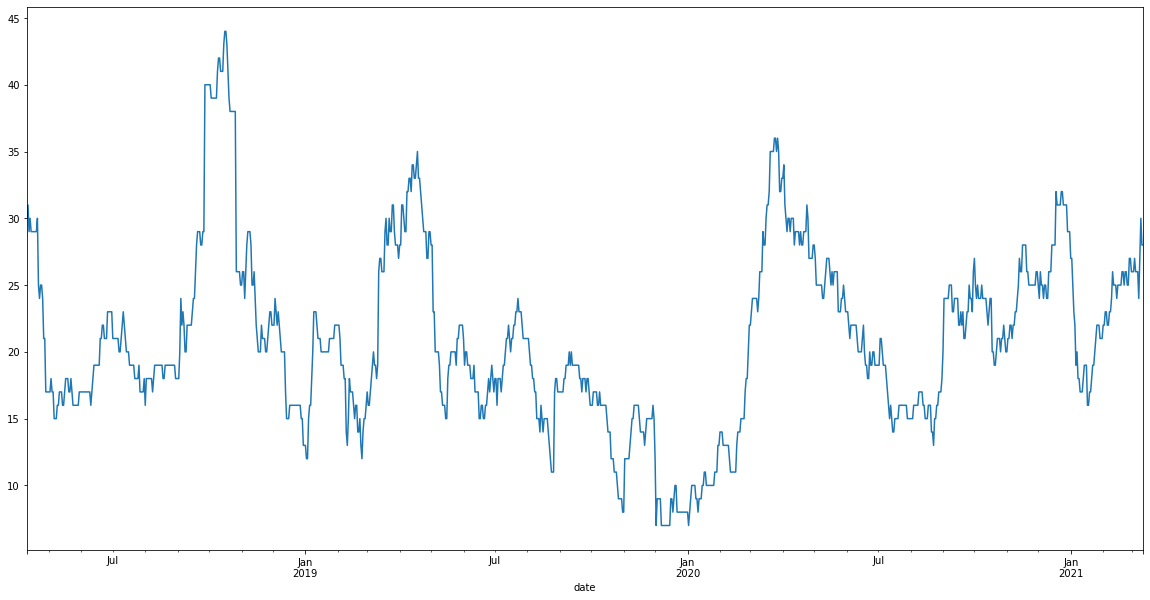

## Data

Current: 28

One year before: 26

Day of maximum: 2018-10-16 00:00:00

count    1067.000000
mean       20.821931
std         6.691273
min         7.000000
25%        16.000000
50%        20.000000
75%        25.000000
max        44.000000
Name: active, dtype: float64

In [142]:
show_author_count_plot(10, "Inhalt")

# Auswertung Anzahl Autor:innen (#Events >= 50; Inhalt)

### Plot

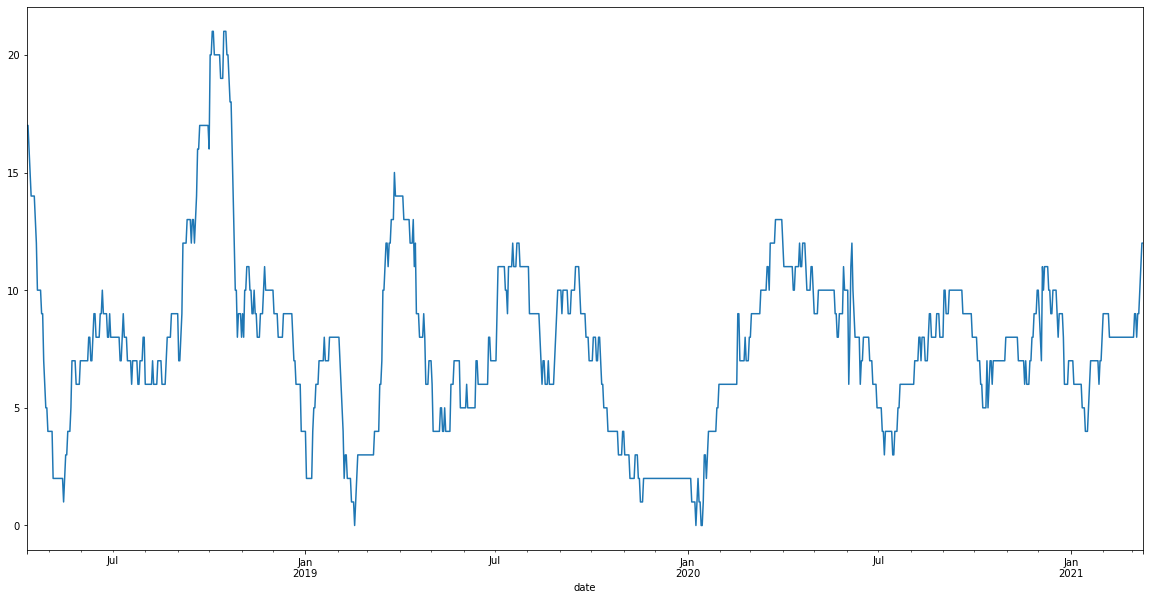

## Data

Current: 12

One year before: 10

Day of maximum: 2018-10-04 00:00:00

count    1067.000000
mean        7.676664
std         3.604439
min         0.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        21.000000
Name: active, dtype: float64

In [143]:
show_author_count_plot(50, "Inhalt")

# Auswertung Anzahl Autor:innen (#Events >= 100; Inhalt)

### Plot

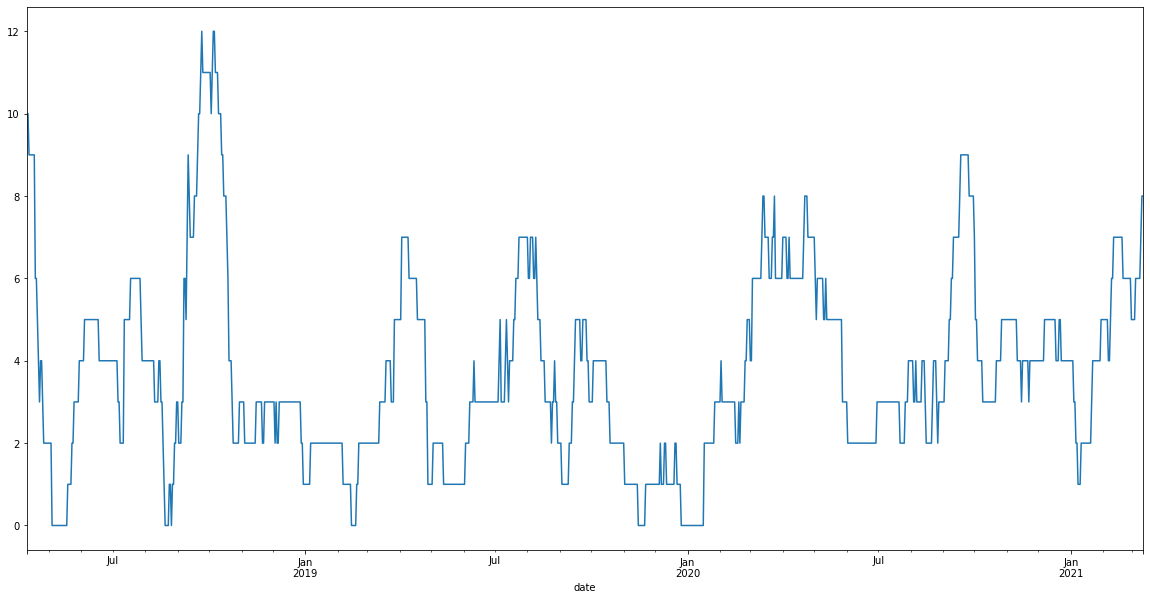

## Data

Current: 8

One year before: 7

Day of maximum: 2018-09-24 00:00:00

count    1067.000000
mean        3.700094
std         2.307104
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        12.000000
Name: active, dtype: float64

In [144]:
show_author_count_plot(100, "Inhalt")

# Auswertung Anzahl Autor:innen (#Events >= 10; Inhalt + Taxonomy)

### Plot

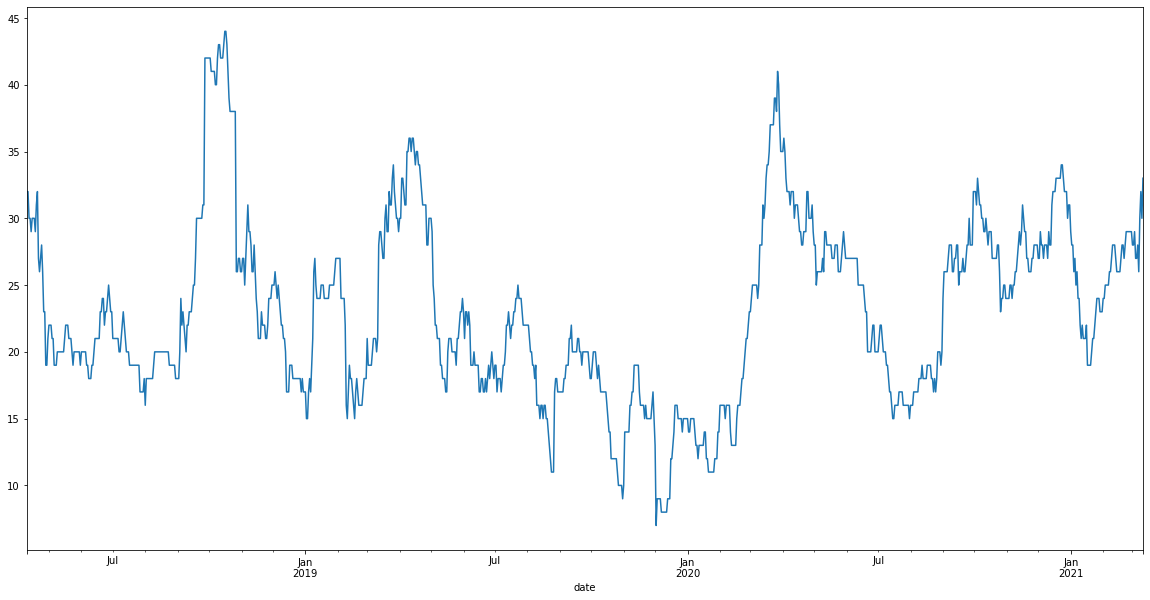

## Data

Current: 33

One year before: 28

Day of maximum: 2018-10-16 00:00:00

count    1067.000000
mean       22.917526
std         6.724876
min         7.000000
25%        18.000000
50%        22.000000
75%        27.000000
max        44.000000
Name: active, dtype: float64

In [146]:
show_author_count_plot(10, "Inhalt + Taxonomy")

# Auswertung Anzahl Autor:innen (#Events >= 100; Inhalt + Taxonomy)

### Plot

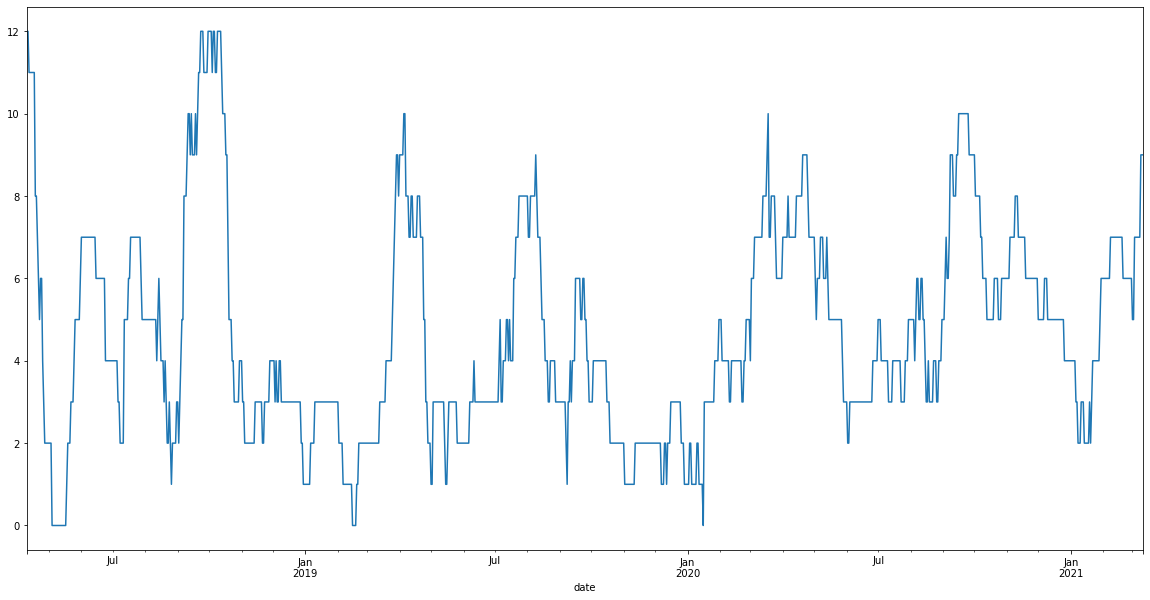

## Data

Current: 9

One year before: 7

Day of maximum: 2018-04-10 00:00:00

count    1067.000000
mean        4.622306
std         2.558653
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        12.000000
Name: active, dtype: float64

In [147]:
show_author_count_plot(100, "Inhalt + Taxonomy")

# Auswertung Anzahl Autor:innen (#Events >= 10; Reviewing)

### Plot

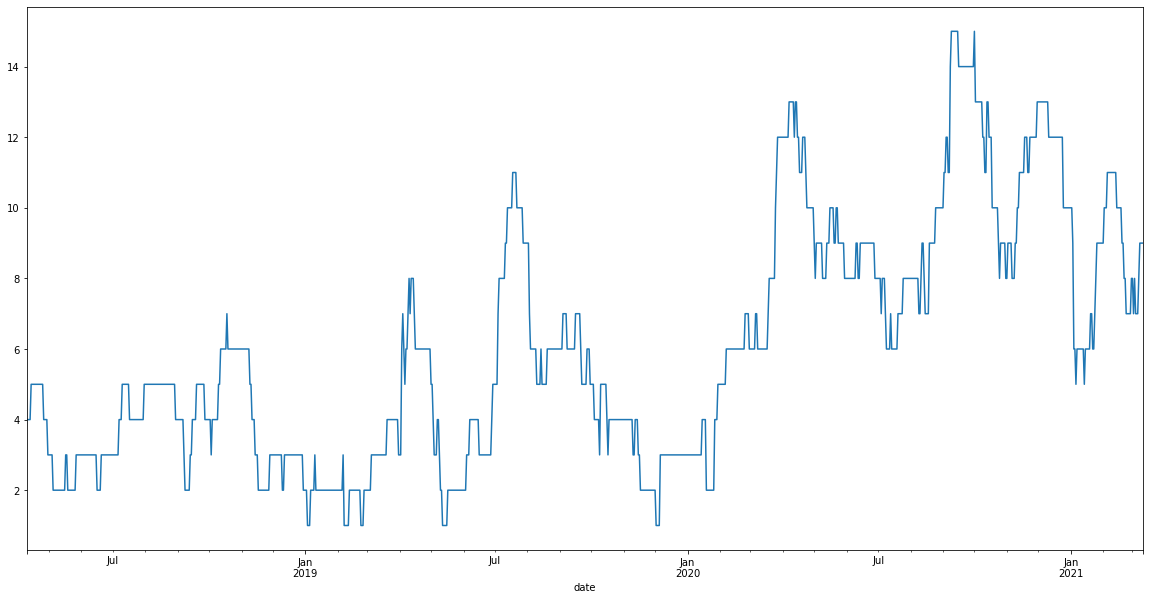

## Data

Current: 9

One year before: 6

Day of maximum: 2020-09-09 00:00:00

count    1067.000000
mean        6.007498
std         3.382986
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        15.000000
Name: active, dtype: float64

In [150]:
show_author_count_plot(10, "Reviewing")

# Auswertung Anzahl Autor:innen (#Events >= 100; Reviewing)

### Plot

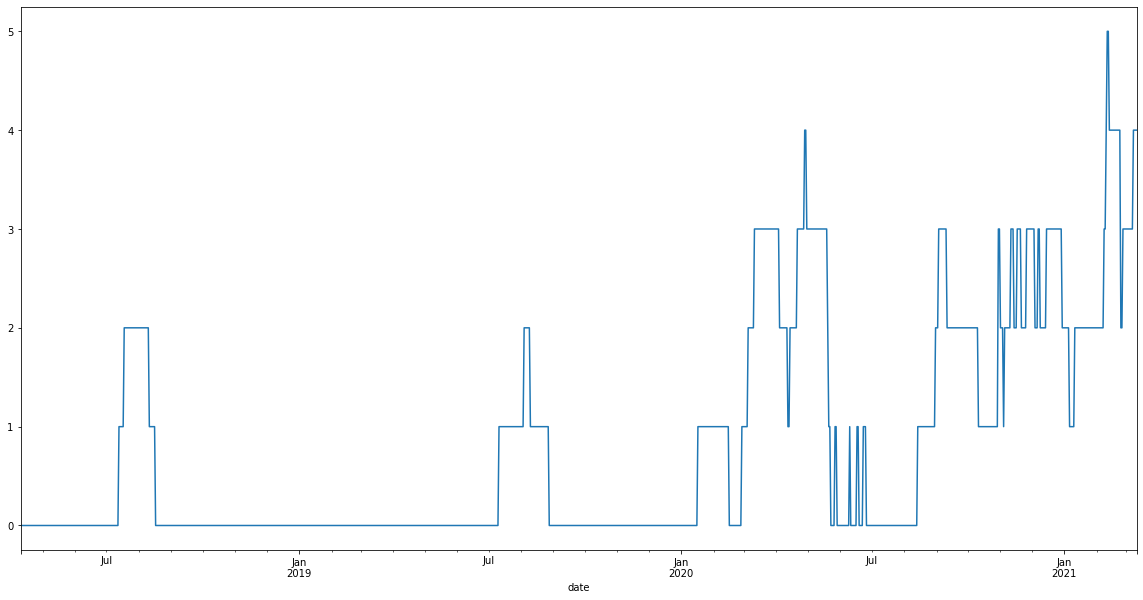

## Data

Current: 4

One year before: 3

Day of maximum: 2021-02-11 00:00:00

count    1067.000000
mean        0.783505
std         1.130753
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         5.000000
Name: active, dtype: float64

In [151]:
show_author_count_plot(100, "Reviewing")

# Auswertung Anzahl Autor:innen (#Events >= 10; Kommentare)

### Plot

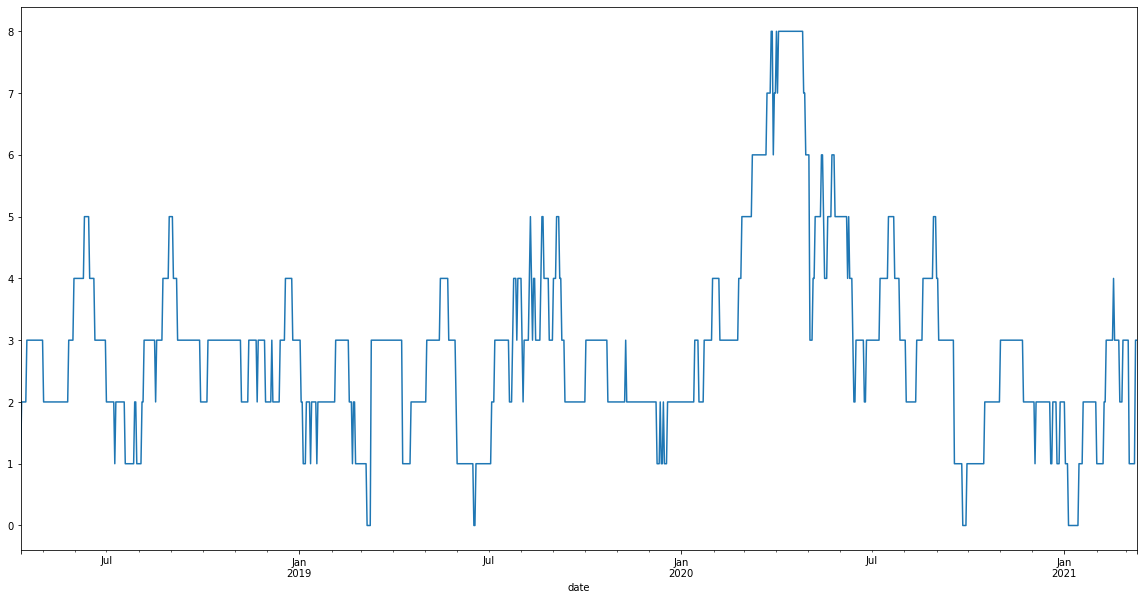

## Data

Current: 3

One year before: 6

Day of maximum: 2020-03-27 00:00:00

count    1067.000000
mean        2.839738
std         1.489675
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: active, dtype: float64

In [152]:
show_author_count_plot(10, "Kommentare")

# Auswertung Anzahl Autor:innen (#Events >= 10; Administration)

### Plot

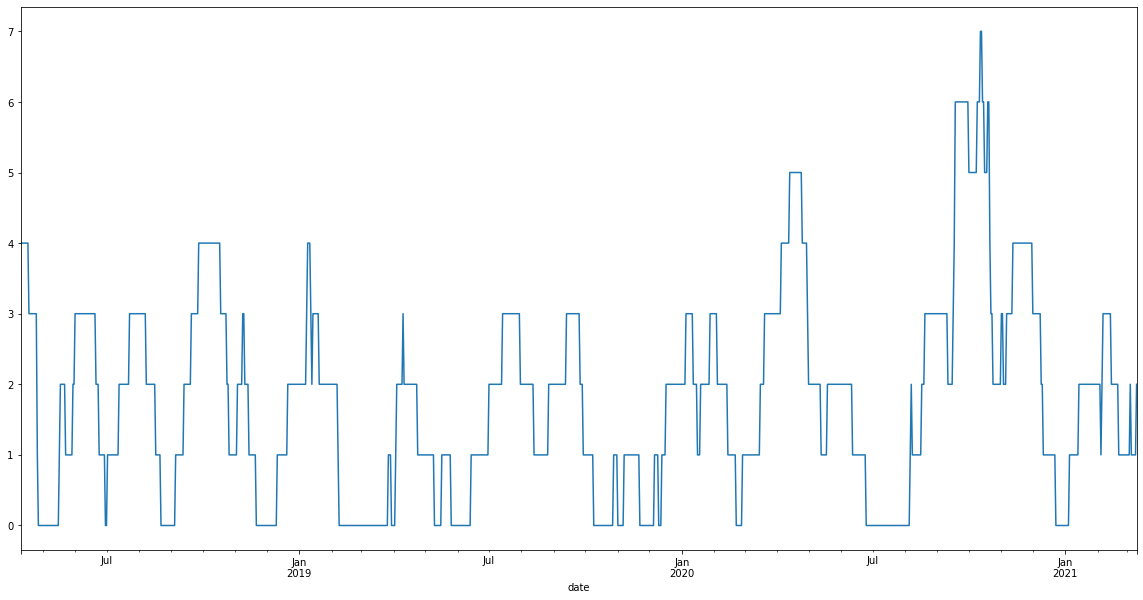

## Data

Current: 2

One year before: 1

Day of maximum: 2020-10-12 00:00:00

count    1066.000000
mean        1.756098
std         1.423012
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: active, dtype: float64

In [154]:
show_author_count_plot(10, "Administration")

In [88]:
import numpy as np

def plot_conversion(df, cond_is_left = lambda e: e > 0 and e < 10,
                    cond_is_right = lambda e: e >= 10,
                    time_interval = 90, relative=True):
    def is_left_to_right_conversion(data):
        middle_index = int(len(data)/2)

        is_left = cond_is_left(data[:middle_index].sum())
        is_right = cond_is_right(data[middle_index:].sum())

        if not is_left or data[middle_index:].sum() == 0:
            return np.nan
        if is_right:
            return 1

        return 0

    df = df.rolling(time_interval, min_periods=time_interval,
                    center=True).aggregate(is_left_to_right_conversion)
    
    def compute_conversion(data):
        data = data.dropna()

        if len(data) == 0:
            return np.nan
        else:
            return data.sum() / len(data) if relative else data.sum()

    df["conversion"] = df.apply(compute_conversion, axis=1)
    
    y_max = df["conversion"].max() + (0.1 if relative else 1)
    df["conversion"].dropna().plot(figsize=(20,10), ylim=(0, y_max))

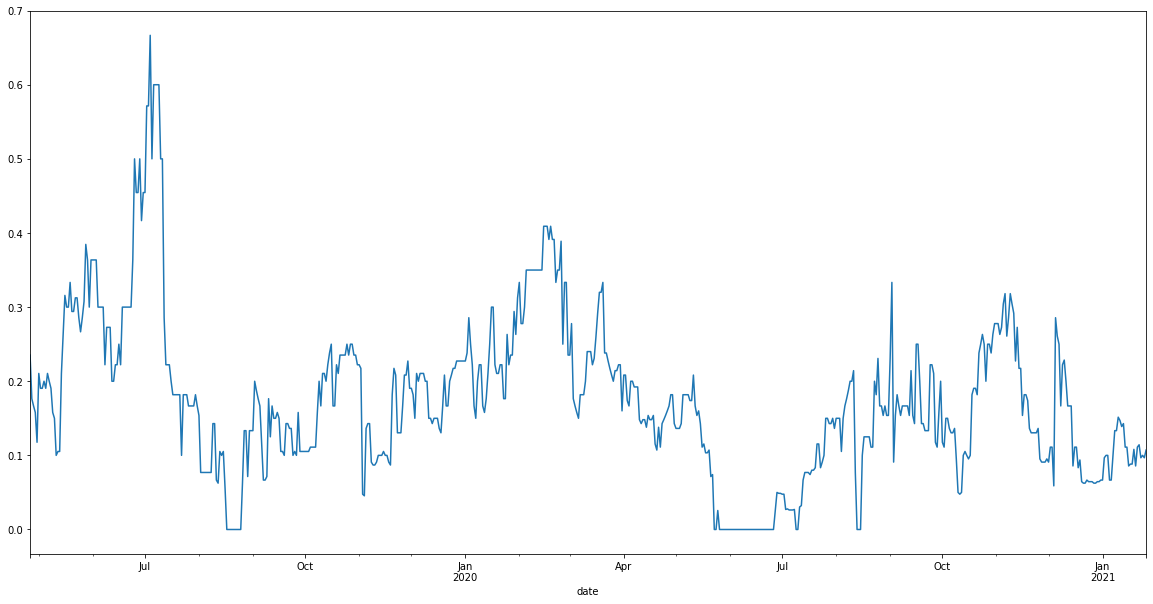

In [85]:
plot_conversion(df, cond_is_left = lambda e: e < 10 and e > 1,
                    cond_is_right = lambda e: e >= 10)

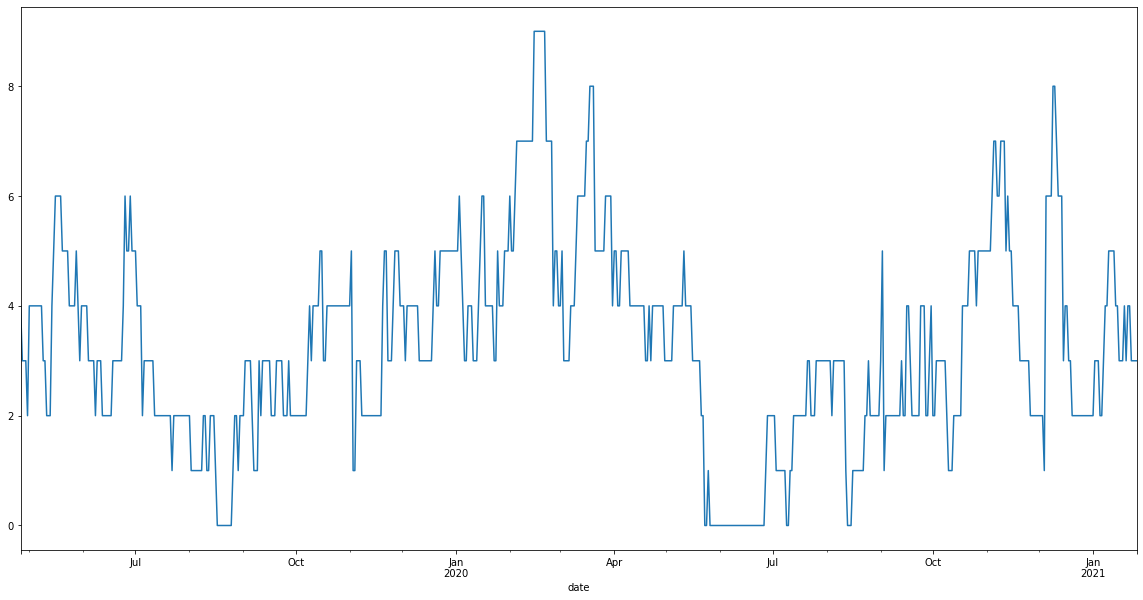

In [84]:
plot_conversion(df, cond_is_left = lambda e: e < 10 and e > 1,
                    cond_is_right = lambda e: e >= 10, relative=False)

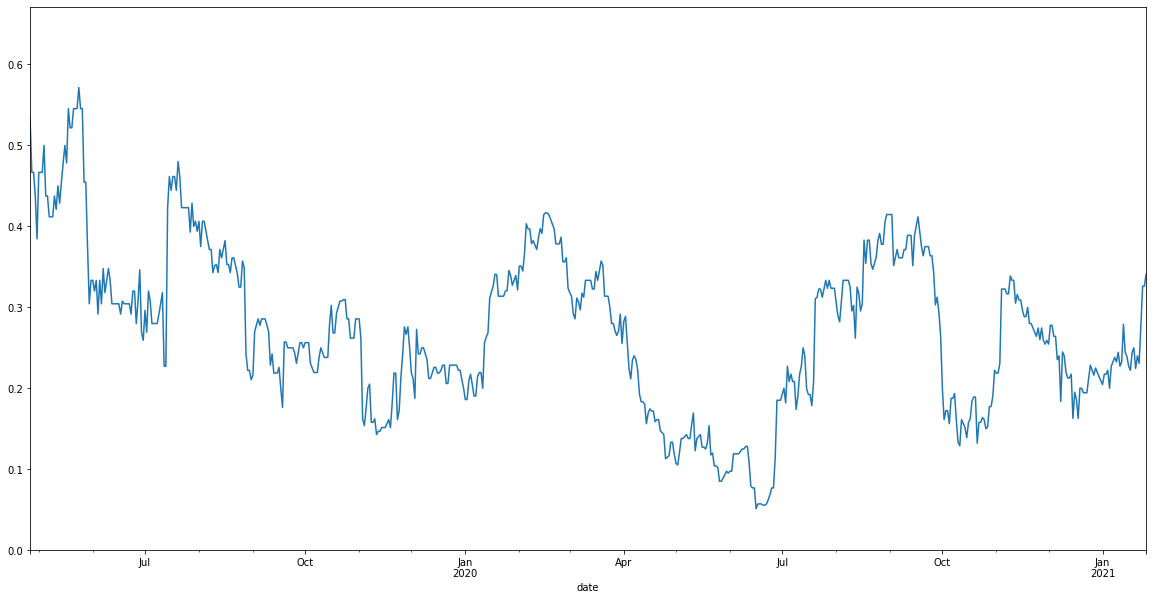

In [89]:
plot_conversion(df, cond_is_left = lambda e: e < 10,
                    cond_is_right = lambda e: e >= 10)

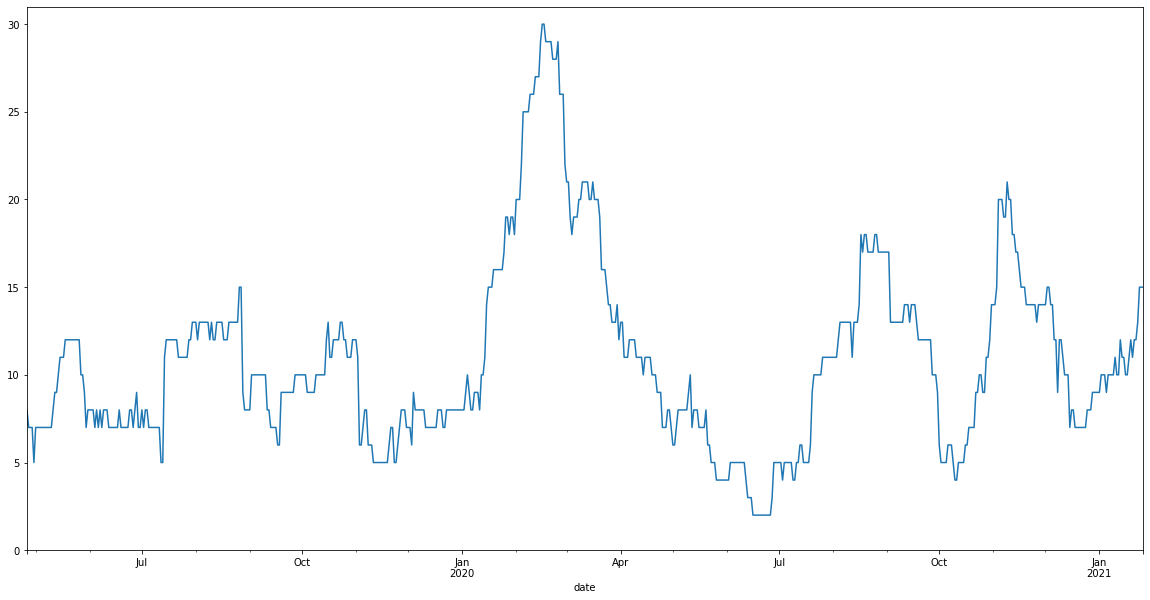

In [90]:
plot_conversion(df, cond_is_left = lambda e: e < 10,
                    cond_is_right = lambda e: e >= 10, relative=False)

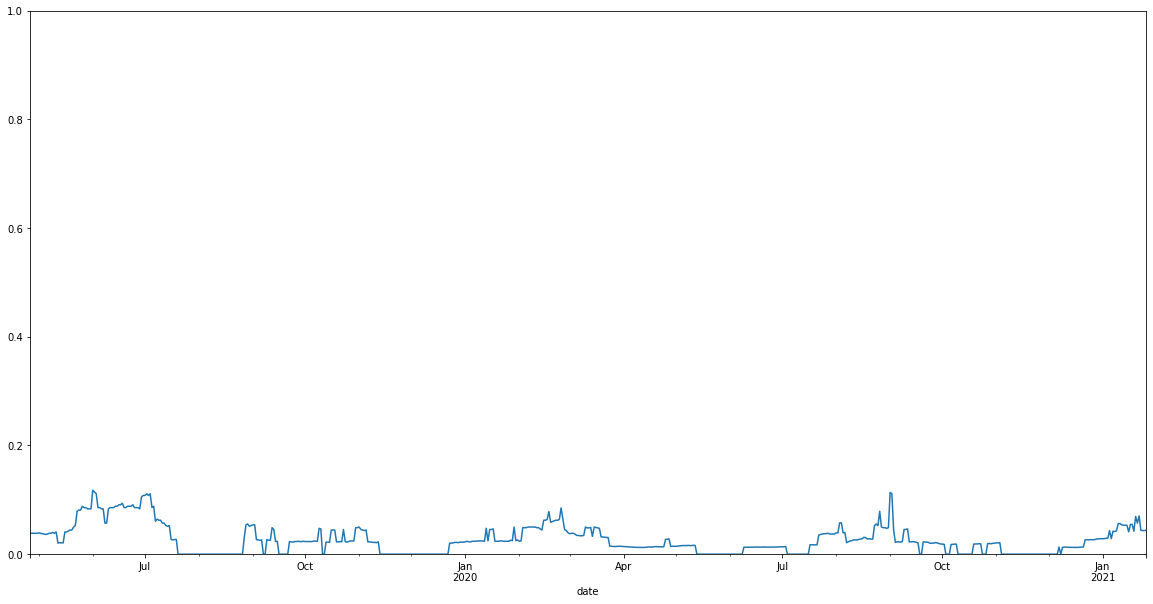

In [75]:
plot_conversion(df, cond_is_left = lambda e: e < 100 and e >= 1,
                    cond_is_right = lambda e: e >= 100)

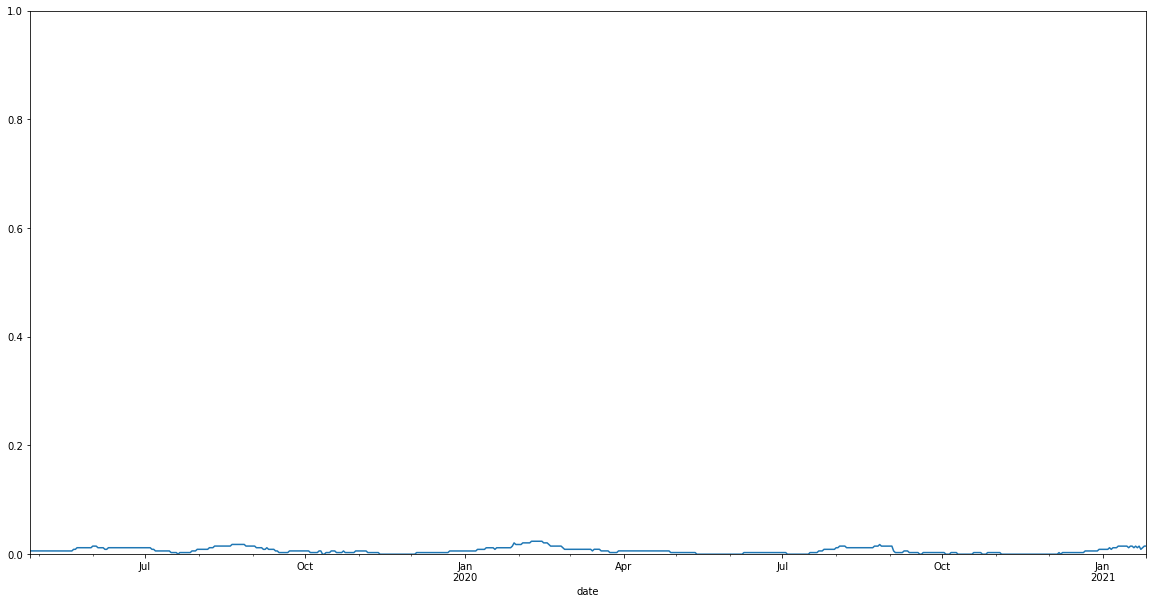

In [76]:
plot_conversion(df, cond_is_left = lambda e: e < 100,
                    cond_is_right = lambda e: e >= 100)

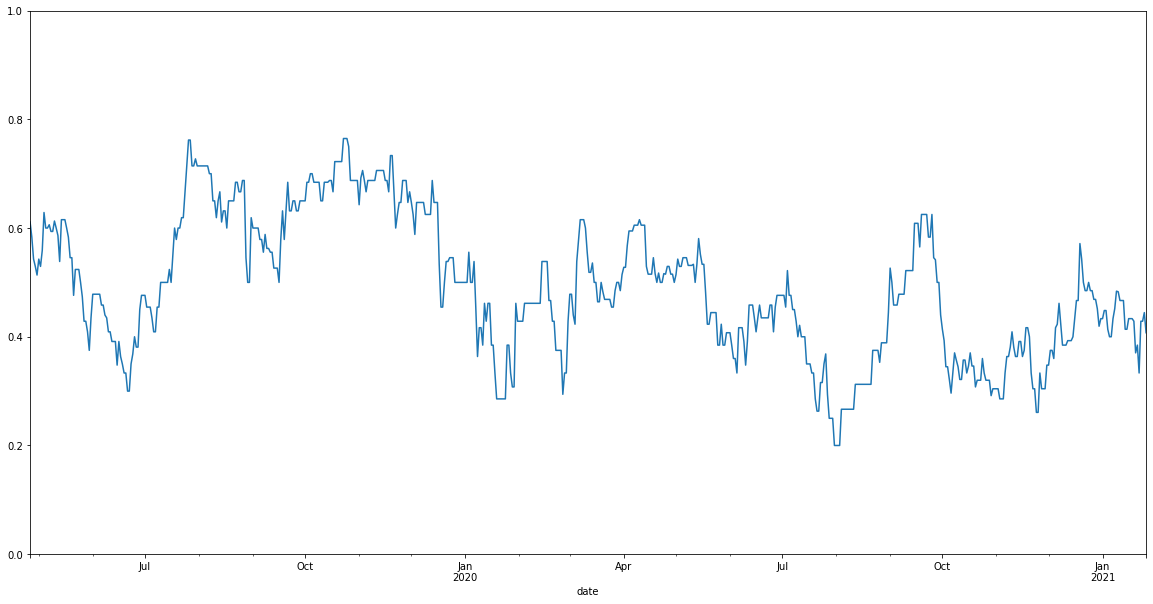

In [77]:
plot_conversion(df, cond_is_left = lambda e: e >= 10,
                    cond_is_right = lambda e: e < 10)

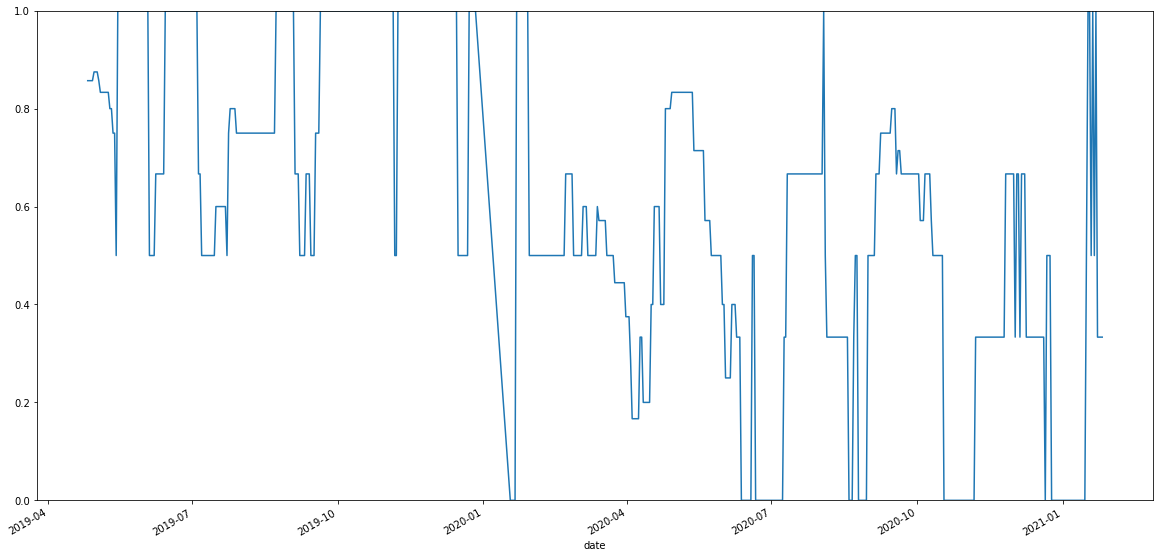

In [78]:
plot_conversion(df, cond_is_left = lambda e: e >= 100,
                    cond_is_right = lambda e: e < 100)

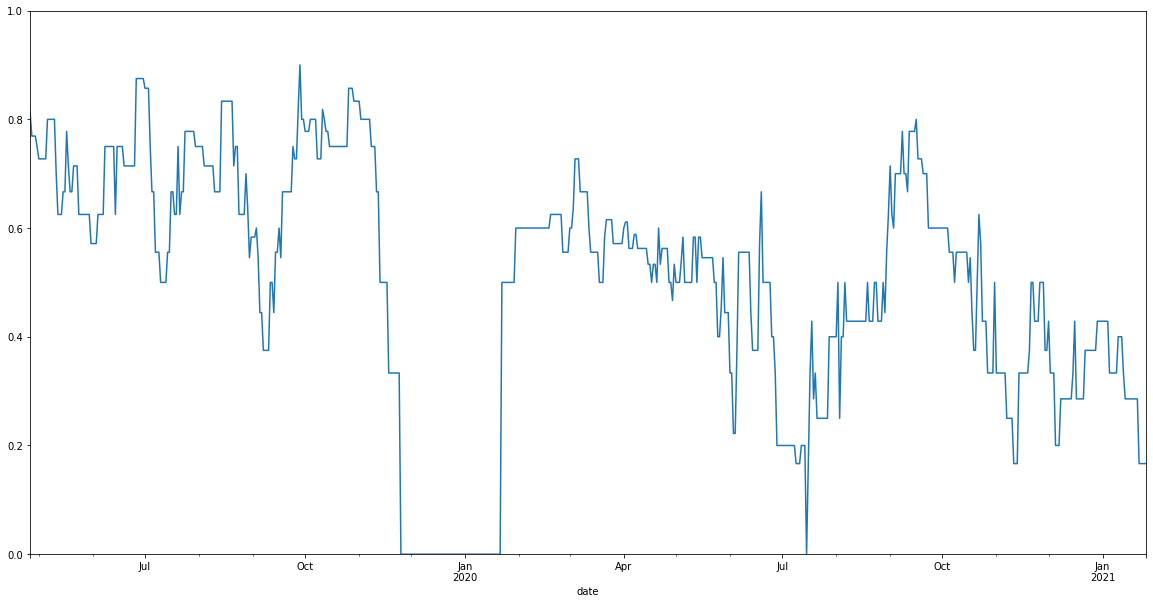

In [79]:
plot_conversion(df, cond_is_left = lambda e: e >= 50,
                    cond_is_right = lambda e: e < 50)

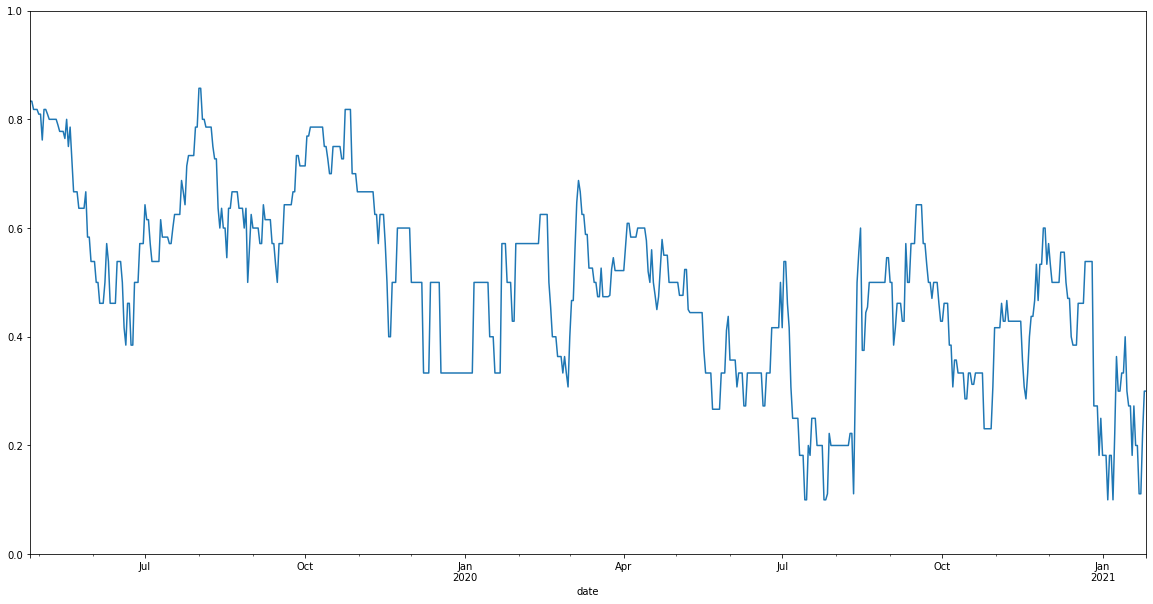

In [80]:
plot_conversion(df, cond_is_left = lambda e: e >= 25,
                    cond_is_right = lambda e: e < 25)

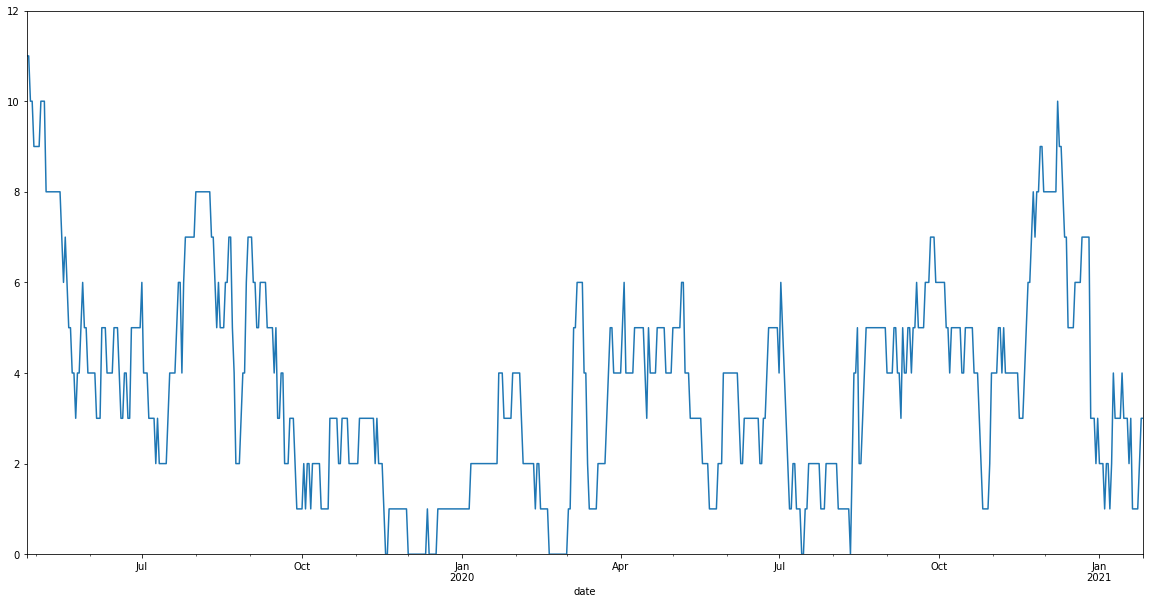

In [91]:
plot_conversion(df, cond_is_left = lambda e: e >= 25,
                    cond_is_right = lambda e: e < 25, relative=False)